In [61]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC, OneClassSVM
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
import os
import random as python_random
import argparse
import numpy as np
import os, sys, time
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [62]:
import os
import pickle
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import eli5

# Construct empty DataFrame
df_sentences = pd.DataFrame(columns=[
    'document', 'file_path', 'split', 'text', 'type'
])

def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    documents = []

    for elem in root.iter():
        if elem.tag == "OP" or elem.tag == "reply":
            all_descendants = [b for b in elem.iter() if b is not elem]
            for desc in all_descendants:
                documents.append((desc.text, desc.tag))
    return documents

# Retrieve premises from all XML files
for split in ['positive', 'negative']:
    for path in glob.glob(os.path.join(f'v2.0/{split}', '*.xml')):
        try:
            for premise, argument in parse_xml(path):
                df_sentences = pd.concat([df_sentences, pd.DataFrame({
                    'document': [path],
                    'file_path': [path],
                    'split': [path.split("/")[1]],
                    'text': [premise],
                    'type': [argument],
                })], axis=0, ignore_index=True)
        except ET.ParseError:
            pass

pickle.dump( df_sentences, open( "./v2.0-processed/df_sentences.pickle", "wb" ) )
#df_sentences.to_pickle('./v2.0-processed/df_sentences.pickle')

In [63]:
df = df_sentences

# Preprocess the train data
documents = df["text"].tolist()
labels = df["type"].tolist()


X_train, X_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2, random_state=1, stratify=labels)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

random_state = 44

# Construct pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC(random_state=random_state)),
])

# Convert labels to numerical values
#encoder = LabelBinarizer()
#y_train_bin = encoder.fit_transform(y_train)
#y_train = np.argmax(y_train_bin, axis=1)

pipe.fit(X_train, y_train)

# Predict dev
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

eli5.show_weights(pipe)


# Predict test
#y_pred = pipe.predict(X_test)
#print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       claim       0.72      0.67      0.69       317
     premise       0.76      0.80      0.78       413

    accuracy                           0.74       730
   macro avg       0.74      0.73      0.74       730
weighted avg       0.74      0.74      0.74       730



/Users/borisdejong/PycharmProjects/ltp/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Feature Name')

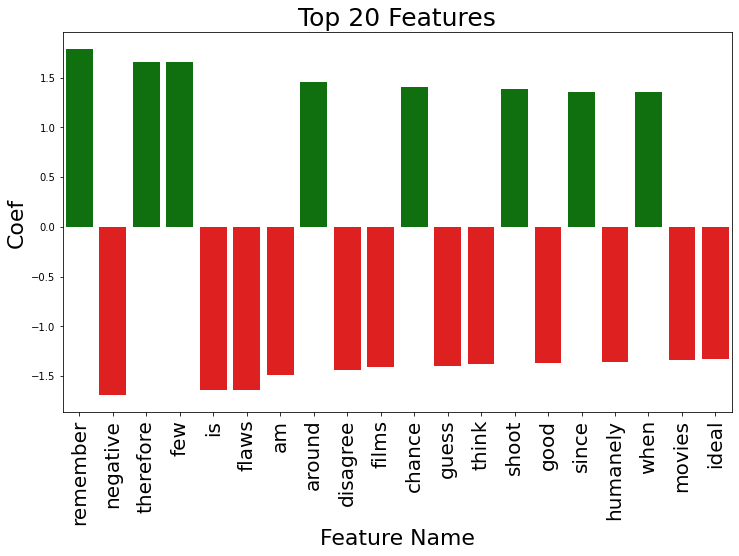

In [64]:
# Get the names of each feature
feature_names = pipe.named_steps["tfidf"].get_feature_names()

# Get the coefficients of each feature
coefs = pipe.named_steps["svc"].coef_.flatten()

import pandas as pd
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)